## System setup

---


##### Importing modules


In [1]:
import os
import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

plt.rcParams.update({"font.size": 16})

import cv2 as cv

from tqdm import tqdm, trange

from toolkit.classes import Environment

2023-01-01 20:41:53.988137: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-01 20:41:54.147213: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/demust/py39/lib/python3.9/site-packages/cv2/../../lib64:
2023-01-01 20:41:54.147244: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-01 20:41:54.986133: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror:

##### Setting up environment


In [2]:
env = Environment()


## Read dataset

---


##### Create image dataframe


In [3]:
images = pd.DataFrame(
    {
        "type": pd.Series(dtype="str"),
        "defect": pd.Series(dtype="int"),
        "defect_str": pd.Series(dtype="str"),
        "path": pd.Series(dtype="str"),
        "filename": pd.Series(dtype="str"),
        "img": pd.Series(dtype="str"),
        "height": pd.Series(dtype="int"),
        "width": pd.Series(dtype="int"),
        "components": pd.Series(dtype="int"),
        "R_mean": pd.Series(dtype="float"),
        "G_mean": pd.Series(dtype="float"),
        "B_mean": pd.Series(dtype="float"),
    }
)

for each in env.DATA_PATH:
    p = each.split("/")
    y = 1 if p[3] == "Defective" else 0
    for img in os.listdir(each):
        data = {
            "type": p[2].lower(),
            "defect": y,
            "defect_str": p[3],
            "path": each,
            "filename": img,
            "img": os.path.join(each, img),
            "height": 0,
            "width": 0,
            "components": 0,
            "R_mean": 0,
            "G_mean": 0,
            "B_mean": 0,
        }
        df = pd.DataFrame(data=data, index=[1])
        images = pd.concat([images, df])

images.reset_index(inplace=True, drop=True)
display(images)
images.info()


type  defect     defect_str                         path filename  \
0    train       0  Non defective  ./data/Train/Non defective/   97.jpg   
1    train       0  Non defective  ./data/Train/Non defective/   79.jpg   
2    train       0  Non defective  ./data/Train/Non defective/  114.jpg   
3    train       0  Non defective  ./data/Train/Non defective/   18.jpg   
4    train       0  Non defective  ./data/Train/Non defective/   46.jpg   
..     ...     ...            ...                          ...      ...   
379   test       1      Defective       ./data/Test/Defective/  381.jpg   
380   test       1      Defective       ./data/Test/Defective/  379.jpg   
381   test       1      Defective       ./data/Test/Defective/  377.jpg   
382   test       1      Defective       ./data/Test/Defective/  380.jpg   
383   test       1      Defective       ./data/Test/Defective/  375.jpg   

                                    img  height  width  components  R_mean  \
0     ./data/Train/Non defective/97.jpg       0      0           0     0.0   
1     ./data/Train/Non defective/79.jpg       0      0           0     0.0   
2    ./data/Train/Non defective/114.jpg       0      0           0     0.0   
3     ./data/Train/Non defective/18.jpg       0      0           0     0.0   
4     ./data/Train/Non defective/46.jpg       0      0           0     0.0   
..                                  ...     ...    ...         ...     ...   
379       ./data/Test/Defective/381.jpg       0      0           0     0.0   
380       ./data/Test/Defective/379.jpg       0      0           0     0.0   
381       ./data/Test/Defective/377.jpg       0      0           0     0.0   
382       ./data/Test/Defective/380.jpg       0      0           0     0.0   
383       ./data/Test/Defective/375.jpg       0      0           0     0.0   

     G_mean  B_mean  
0       0.0     0.0  
1       0.0     0.0  
2       0.0     0.0  
3       0.0     0.0  
4       0.0     0.0  
..      ...     ...  
379     0.0     0.0  
380     0.0     0.0  
381     0.0     0.0  
382     0.0     0.0  
383     0.0     0.0  

[384 rows x 12 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   type        384 non-null    object 
 1   defect      384 non-null    int64  
 2   defect_str  384 non-null    object 
 3   path        384 non-null    object 
 4   filename    384 non-null    object 
 5   img         384 non-null    object 
 6   height      384 non-null    int64  
 7   width       384 non-null    int64  
 8   components  384 non-null    int64  
 9   R_mean      384 non-null    float64
 10  G_mean      384 non-null    float64
 11  B_mean      384 non-null    float64
dtypes: float64(3), int64(4), object(5)
memory usage: 36.1+ KB


##### Generate random sample from training data


In [4]:
N_samples = 3
random_sample_idx = []
idx1 = np.random.choice(
    images[(images.type == "train") & (images.defect == 0)].index, N_samples
)
idx2 = np.random.choice(
    images[(images.type == "train") & (images.defect == 1)].index, N_samples
)
random_sample_idx = np.concatenate([idx1, idx2])
random_sample = images.iloc[random_sample_idx].copy()
random_sample


type  defect     defect_str                         path filename  \
29   train       0  Non defective  ./data/Train/Non defective/  119.jpg   
63   train       0  Non defective  ./data/Train/Non defective/   81.jpg   
95   train       0  Non defective  ./data/Train/Non defective/   82.jpg   
174  train       1      Defective      ./data/Train/Defective/  188.jpg   
284  train       1      Defective      ./data/Train/Defective/  240.jpg   
265  train       1      Defective      ./data/Train/Defective/  197.jpg   

                                    img  height  width  components  R_mean  \
29   ./data/Train/Non defective/119.jpg       0      0           0     0.0   
63    ./data/Train/Non defective/81.jpg       0      0           0     0.0   
95    ./data/Train/Non defective/82.jpg       0      0           0     0.0   
174      ./data/Train/Defective/188.jpg       0      0           0     0.0   
284      ./data/Train/Defective/240.jpg       0      0           0     0.0   
265      ./data/Train/Defective/197.jpg       0      0           0     0.0   

     G_mean  B_mean  
29      0.0     0.0  
63      0.0     0.0  
95      0.0     0.0  
174     0.0     0.0  
284     0.0     0.0  
265     0.0     0.0

##### Visualize random sample


100%|██████████| 6/6 [00:02<00:00,  2.67it/s]


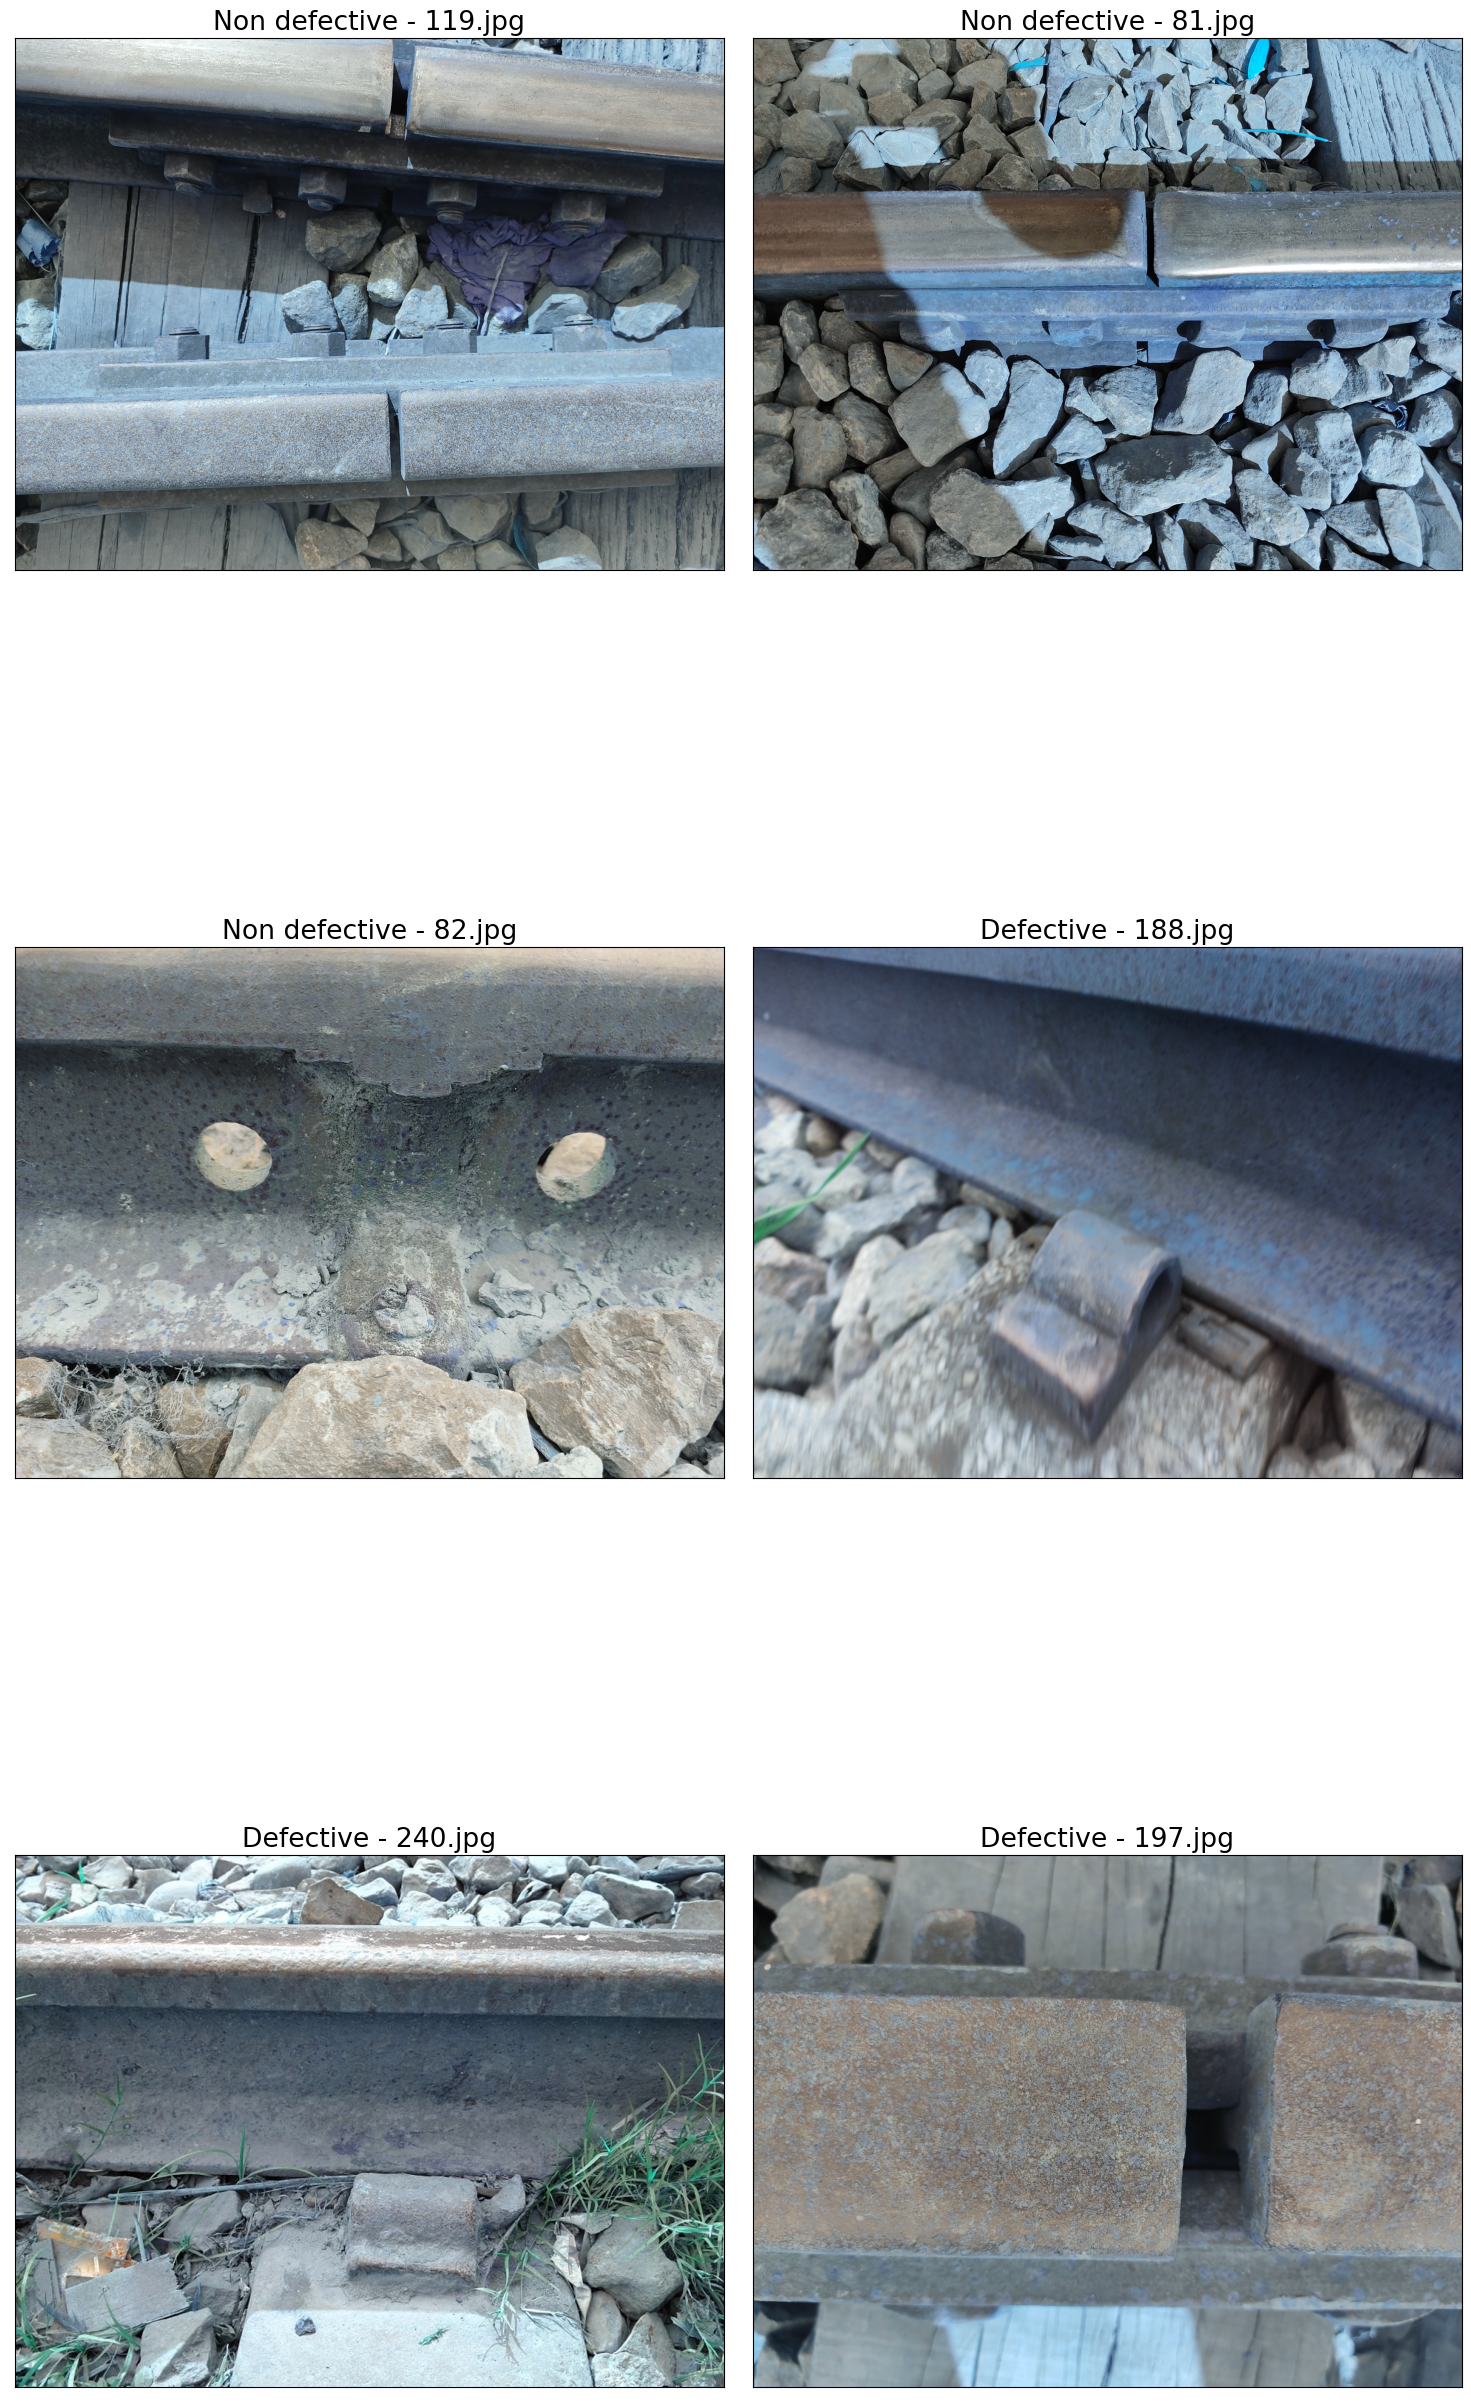

In [5]:
fig, ax = plt.subplots(N_samples, 2, figsize=(15, 10 * N_samples), tight_layout=True)
ax = ax.flatten()

for i, idx in enumerate(tqdm(random_sample.index)):
    image = cv.imread(images.img[idx])
    ax[i].imshow(image)
    ax[i].set_xticks(ticks=[])
    ax[i].set_yticks(ticks=[])
    ax[i].set_title(f"{images.defect_str[idx]} - {images.filename[idx]}")

plt.show()


## Data exploration

---


##### Extract basic features from the images


In [6]:
height = []
width = []
components = []
R_mean = []
G_mean = []
B_mean = []

for i in tqdm(images.index):
    image = cv.imread(images.iloc[i].img)
    height.append(image.shape[0])
    width.append(image.shape[1])
    components.append(image.shape[2])
    R_mean.append(np.mean(image[:, :, 0]))
    G_mean.append(np.mean(image[:, :, 1]))
    B_mean.append(np.mean(image[:, :, 2]))

images.update({"height": height})
images.update({"width": width})
images.update({"components": components})
images.update({"R_mean": R_mean})
images.update({"G_mean": G_mean})
images.update({"B_mean": B_mean})


100%|██████████| 384/384 [01:28<00:00,  4.34it/s]


##### Shape of the images


Minimum  height  :  148  @  243
Maximum  height  :  8000  @  241
Minimum  width  :  156  @  297
Maximum  width  :  8000  @  152
Minimum  components  :  3  @  0
Maximum  components  :  3  @  0
Minimum sizes:
height    322
width     156
Name: 297, dtype: int64
height    148
width     194
Name: 243, dtype: int64


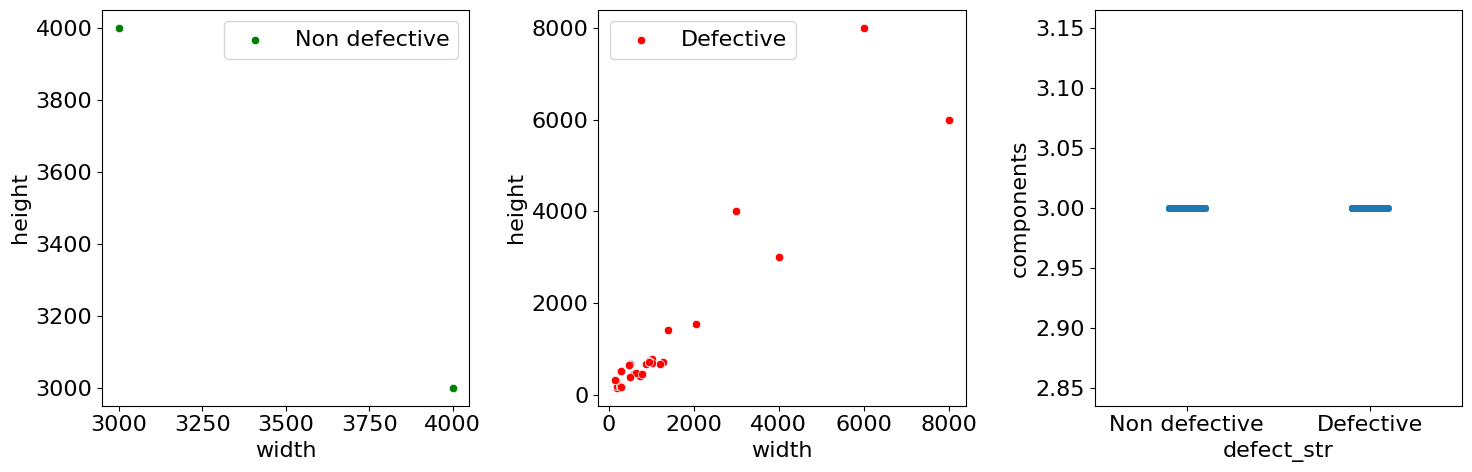

<Figure size 640x480 with 0 Axes>

In [7]:
dims = ["height", "width", "components"]
for dim in dims:
    print("Minimum ", dim, " : ", images[dim].min(), " @ ", images[dim].argmin())
    print("Maximum ", dim, " : ", images[dim].max(), " @ ", images[dim].argmax())

min_height = np.argmin(images.height)
min_width = np.argmin(images.width)
print("Minimum sizes:")
print(images[["height", "width"]].iloc[min_width])
print(images[["height", "width"]].iloc[min_height])

fig, ax = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)
sns.scatterplot(
    x="width",
    y="height",
    data=images[images.defect == 0],
    ax=ax[0],
    label="Non defective",
    color="green",
)
sns.scatterplot(
    x="width",
    y="height",
    data=images[images.defect == 1],
    ax=ax[1],
    label="Defective",
    color="red",
)
sns.stripplot(x="defect_str", y="components", data=images, ax=ax[2])
plt.show()
plt.savefig(os.path.join(env.plot_folder, "shapes.png"))


##### Main component distribution of the images


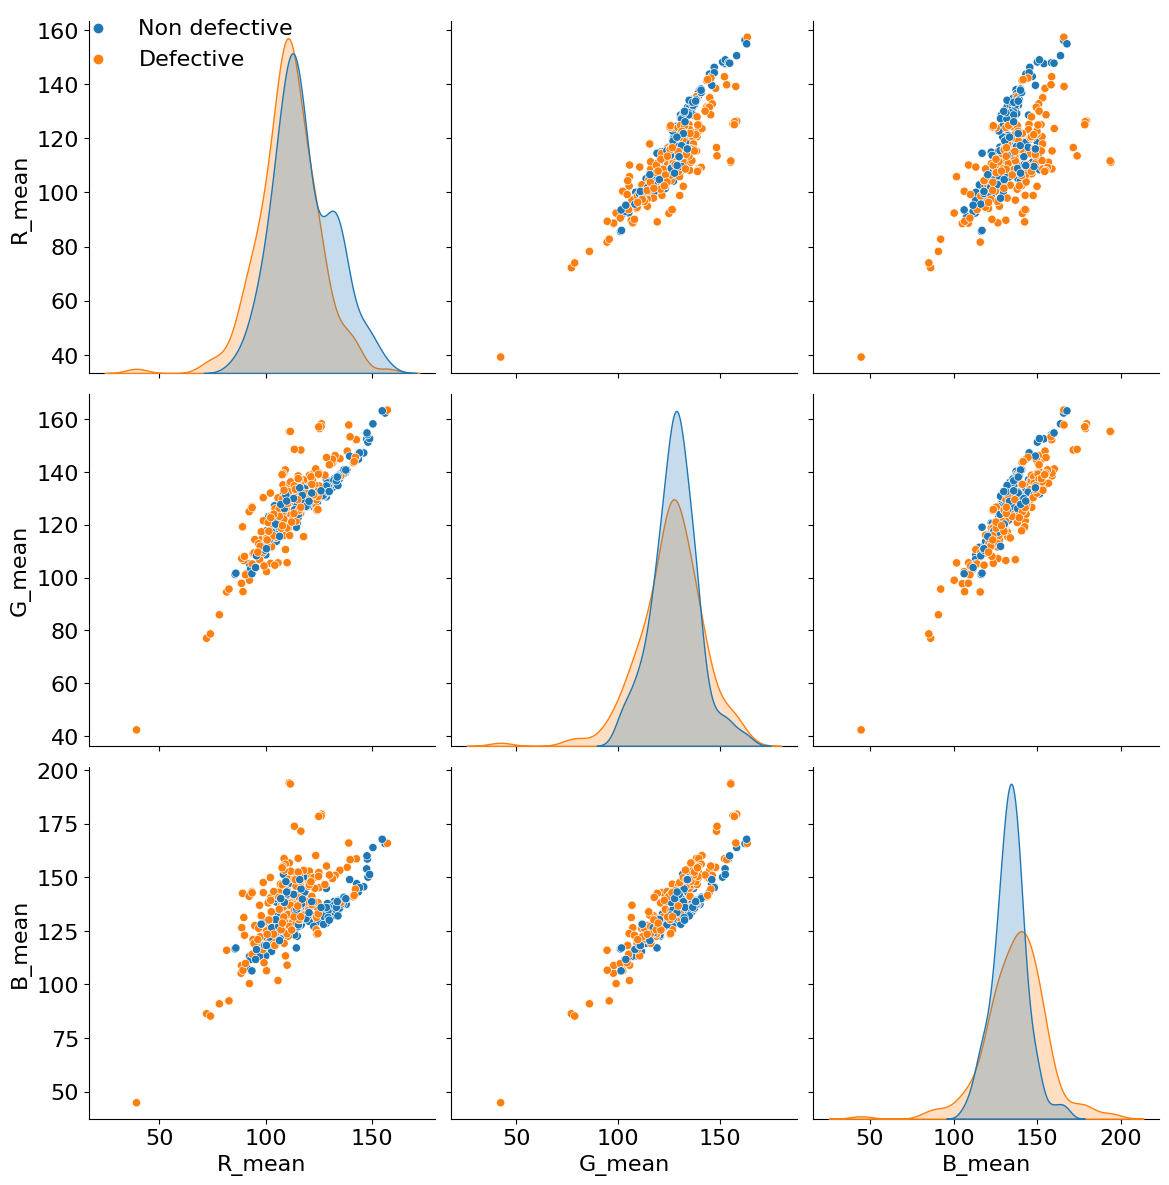

In [8]:
cols = ["R_mean", "G_mean", "B_mean"]
plot = sns.pairplot(data=images, vars=cols, hue="defect_str", height=4)
sns.move_legend(plot, loc="upper left", bbox_to_anchor=(0.05, 1.0), title=None)
plt.savefig(os.path.join(env.plot_folder, "comp_pair.png"))
plt.show()


##### Dataset balance


In [9]:
images.groupby(["type", "defect_str"]).count()


defect  path  filename  img  height  width  \
type       defect_str                                                  
test       Defective          11    11        11   11      11     11   
           Non defective      11    11        11   11      11     11   
train      Defective         150   150       150  150     150    150   
           Non defective     150   150       150  150     150    150   
validation Defective          31    31        31   31      31     31   
           Non defective      31    31        31   31      31     31   

                          components  R_mean  G_mean  B_mean  
type       defect_str                                         
test       Defective              11      11      11      11  
           Non defective          11      11      11      11  
train      Defective             150     150     150     150  
           Non defective         150     150     150     150  
validation Defective              31      31      31      31  
           Non defective          31      31      31      31

##### Basic information on random sample: color components on RGB and HSV


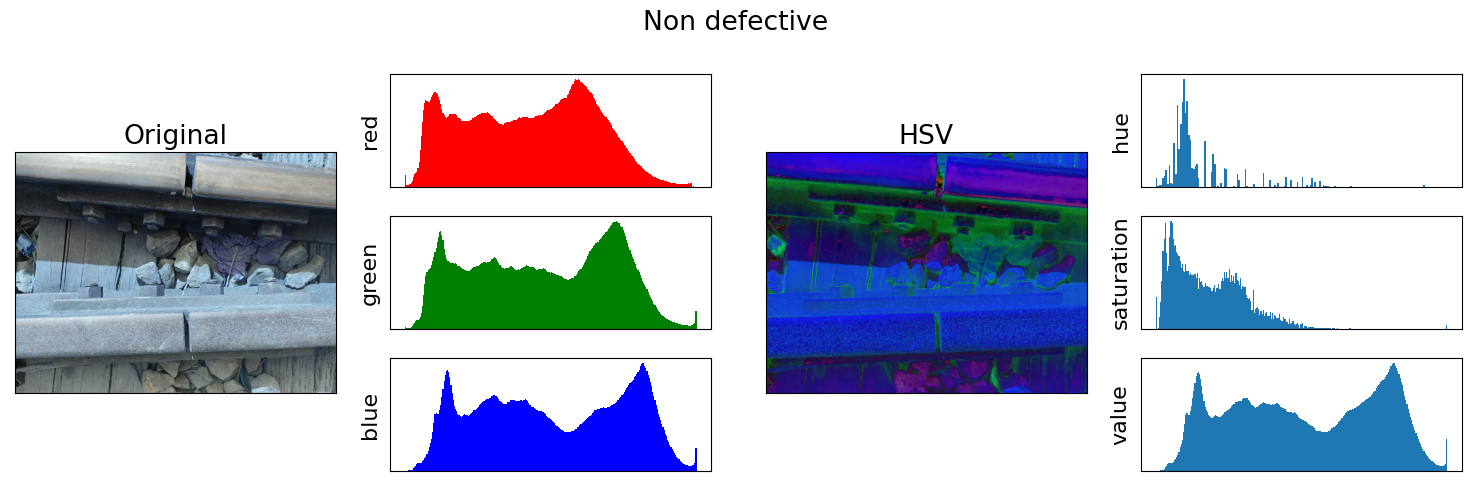

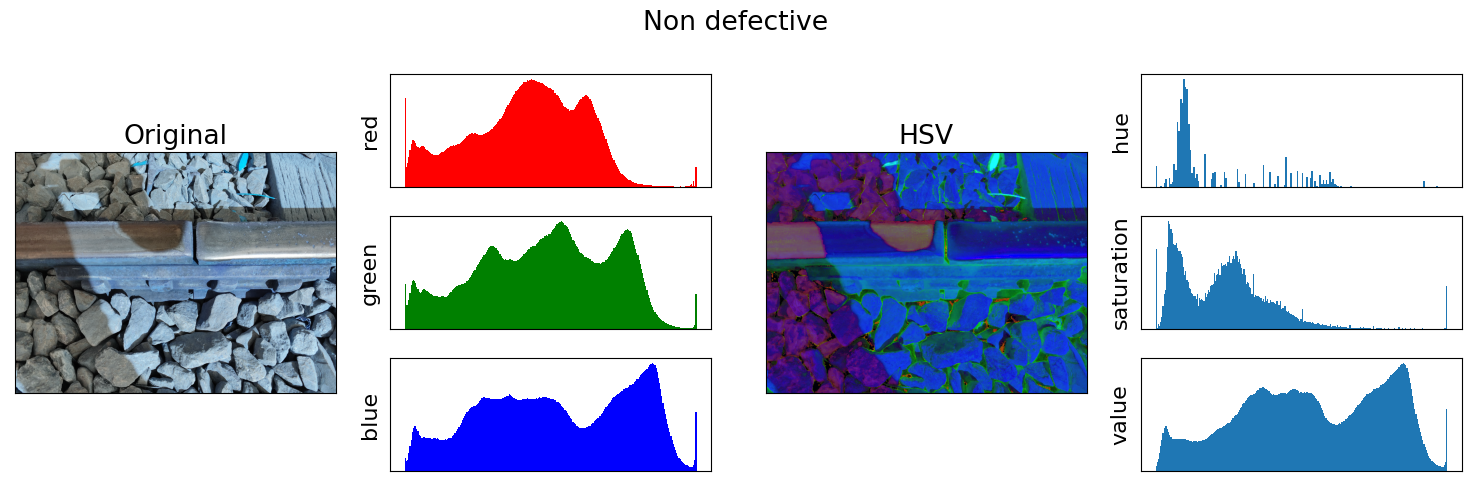

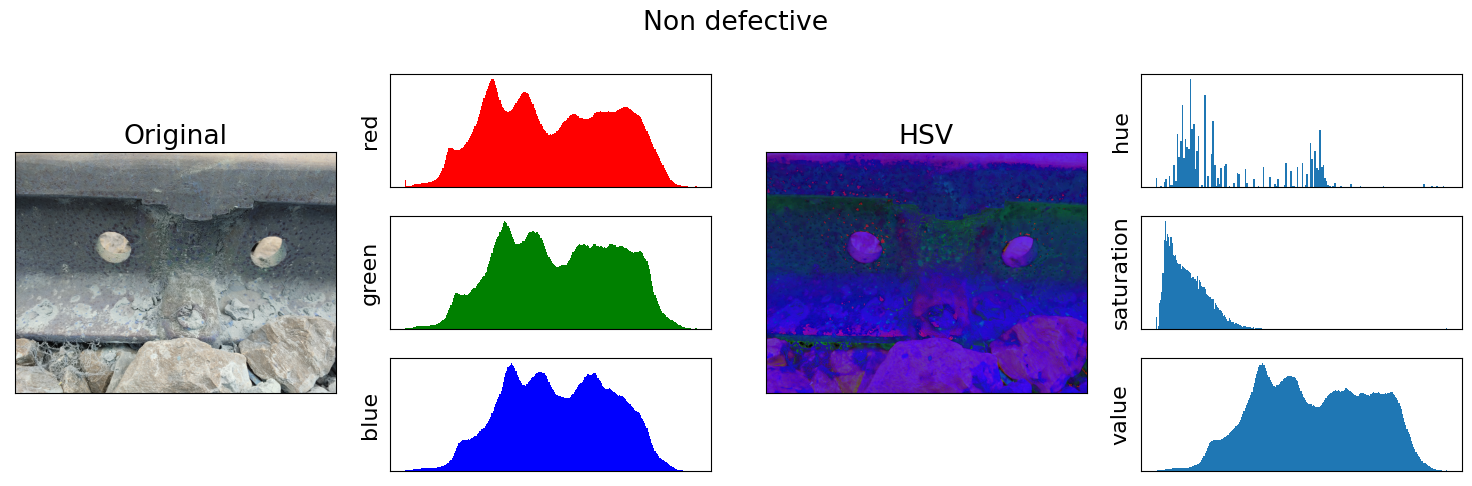

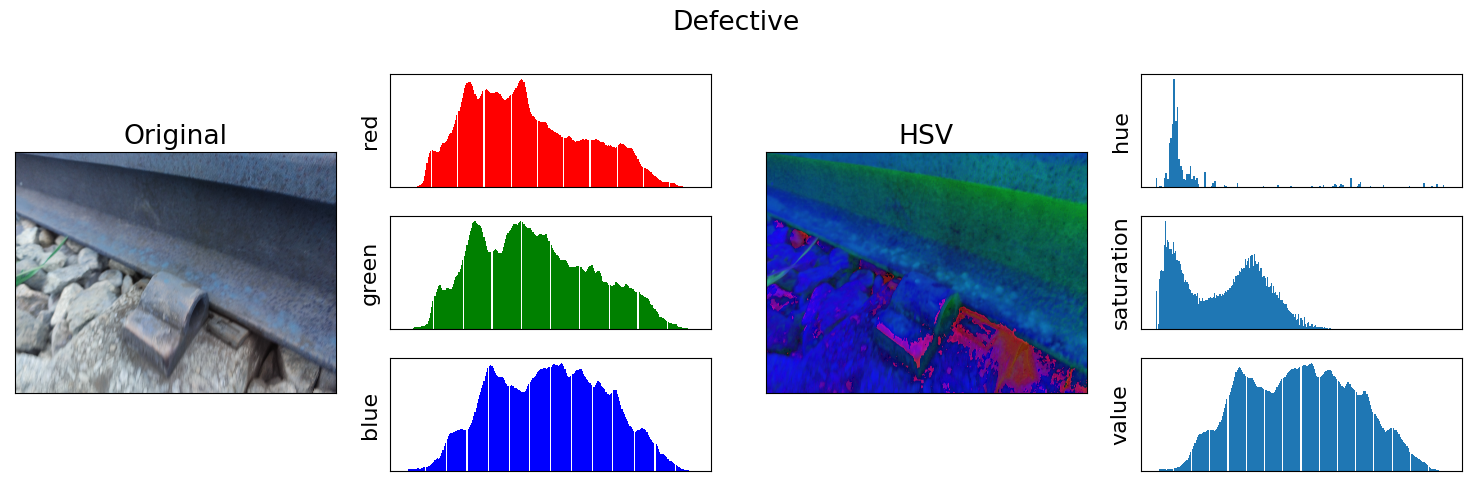

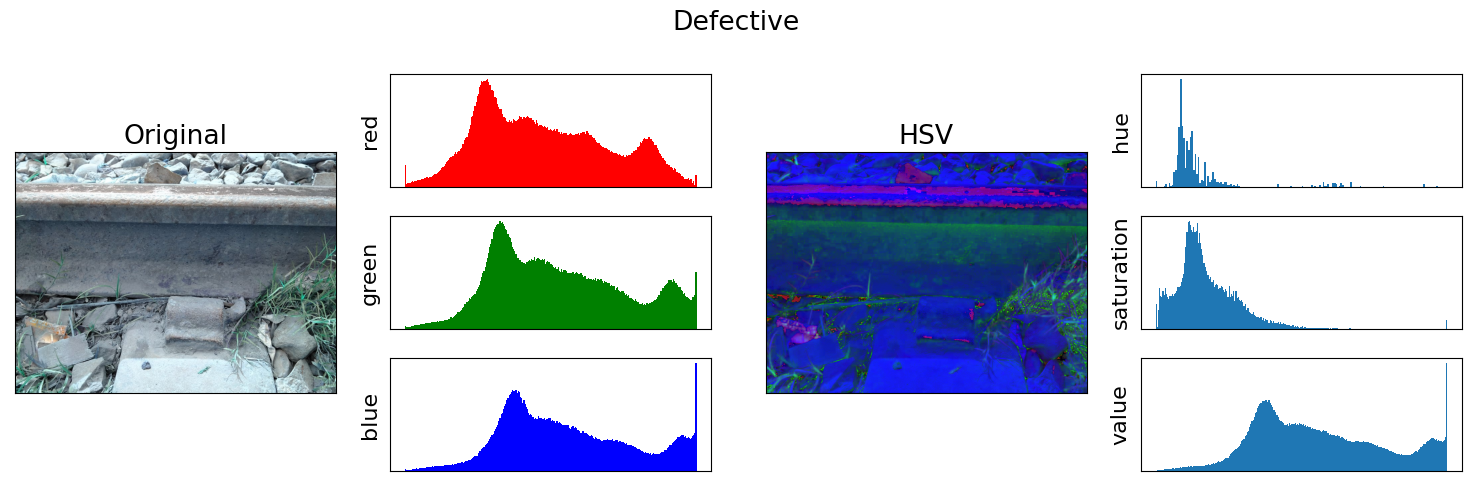

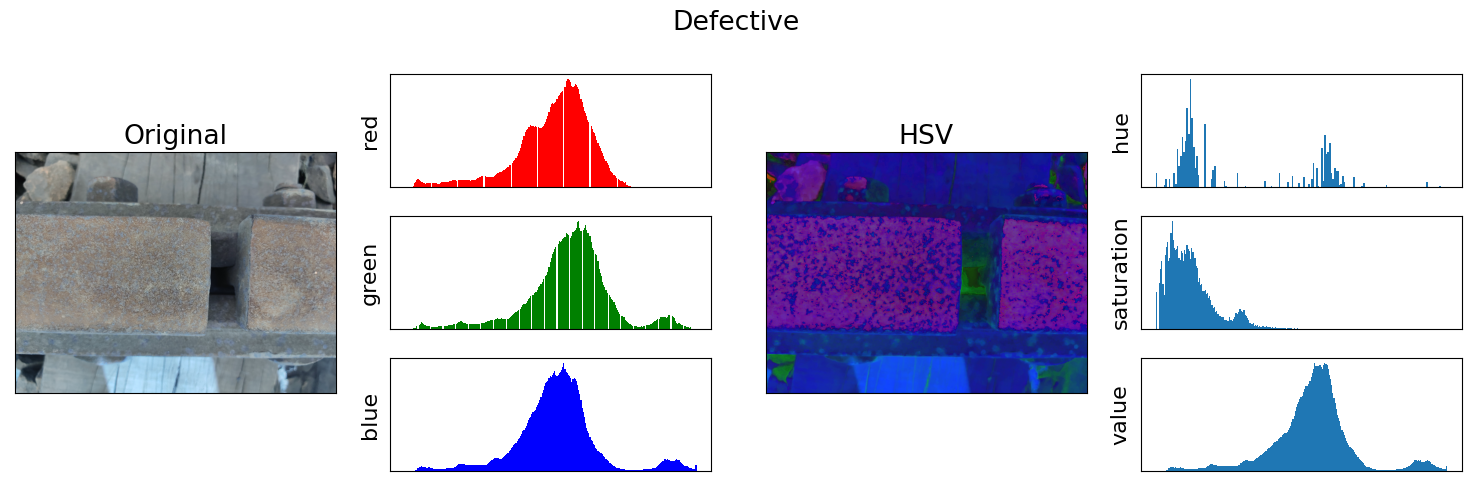

In [10]:
gs = gridspec.GridSpec(3, 4)

for s, sample in enumerate(random_sample[["img", "defect_str"]].itertuples()):
    fig = plt.figure(figsize=(15, 5), tight_layout=True)
    fig.suptitle(sample.defect_str)
    ax = [
        fig.add_subplot(gs[:, 0]),
        fig.add_subplot(gs[0, 1]),
        fig.add_subplot(gs[1, 1]),
        fig.add_subplot(gs[2, 1]),
        fig.add_subplot(gs[:, 2]),
        fig.add_subplot(gs[0, 3]),
        fig.add_subplot(gs[1, 3]),
        fig.add_subplot(gs[2, 3]),
    ]
    image = cv.imread(sample.img)
    ax[0].imshow(image)
    ax[0].set_title("Original")
    ax[0].set_xticks(ticks=[])
    ax[0].set_yticks(ticks=[])

    for c, component in enumerate(["red", "green", "blue"]):
        ax[c + 1].hist(image[:, :, c].ravel(), bins=256, color=component)
        ax[c + 1].set_ylabel(component)
        ax[c + 1].set_xticks(ticks=[])
        ax[c + 1].set_yticks(ticks=[])

    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    ax[4].imshow(hsv)
    ax[4].set_title("HSV")
    ax[4].set_xticks(ticks=[])
    ax[4].set_yticks(ticks=[])

    for c, component in enumerate(["hue", "saturation", "value"]):
        bins = [180, 256, 256]
        ax[c + 5].hist(hsv[:, :, c].ravel(), bins=bins[c])
        ax[c + 5].set_ylabel(component)
        ax[c + 5].set_xticks(ticks=[])
        ax[c + 5].set_yticks(ticks=[])

    filename = f"comp_analysis_{str(s)}.png"
    plt.savefig(os.path.join(env.plot_folder, filename))
    plt.show()
